<a href="https://colab.research.google.com/github/kar1myasser/Cafe-Sales-Data-Cleaning/blob/main/Cafe_data_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [359]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

In [360]:
df = pd.read_csv('/dirty_cafe_sales.csv')

In [361]:
print(df.shape)
df.head()

(10000, 8)


,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,ERROR,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,UNKNOWN,UNKNOWN,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


We can see our first issue in the 3rd and 4th rows they contain missing values in the "Total Spent", "Payment Method" and "Location" columns (They will be compared after the cleaning)

In [362]:
df.describe(include='all')

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,9667,9862,9821,9827,7421,6735,9841
unique,10000,10,7,8,19,5,4,367
top,TXN_9226047,Juice,5,3.0,6.0,Digital Wallet,Takeaway,UNKNOWN
freq,1,1171,2013,2429,979,2291,3022,159


Second issue all data types are of the object type, which needs to be fixed

In [363]:
df.dtypes

,0
Transaction ID,object
Item,object
Quantity,object
Price Per Unit,object
Total Spent,object
Payment Method,object
Location,object
Transaction Date,object


This is the needed data format

Transaction ID: object

Item: object

Quantity: int

Price Per Unit:	float

Total Spent:	float

Payment Method:	object

Location:	object

Transaction Date:	date



Check for duplicate rows

In [364]:
duplicates = df[df.duplicated(subset=['Transaction ID'], keep=False)]
print(f"Duplicate IDs found: {len(duplicates)}")
df.duplicated().sum()

Duplicate IDs found: 0


np.int64(0)

0 duplicate rows found

In [365]:
# Check for duplicate records without the ID because a new ID could be generated for every transaction even if it was a duplicate
duplicate_content = df.duplicated(subset=['Item', 'Quantity', 'Price Per Unit', 'Total Spent', 'Payment Method', 'Location','Transaction Date'], keep=False)
print(f"Duplicates based on content: {duplicate_content.sum()}")

Duplicates based on content: 279


These 'duplicate' records could actually be real observations, without a precise timestamp or customer ID, identifying these as duplicates would risk deleting valid sales data. Therefore, I have decided not to drop any rows, as the unique Transaction IDs suggest these are distinct valid transactions.

In [366]:
# Check the values in each column to check for inconsistencies
for col in df:
  print(df[col].value_counts(dropna=False))
  print('_________')

Transaction ID
TXN_9226047    1
TXN_8567525    1
TXN_4583012    1
TXN_6796890    1
TXN_9933628    1
              ..
TXN_3160411    1
TXN_7034554    1
TXN_4271903    1
TXN_4977031    1
TXN_1961373    1
Name: count, Length: 10000, dtype: int64
_________
Item
Juice       1171
Coffee      1165
Salad       1148
Cake        1139
Sandwich    1131
Smoothie    1096
Cookie      1092
Tea         1089
UNKNOWN      344
NaN          333
ERROR        292
Name: count, dtype: int64
_________
Quantity
5          2013
2          1974
4          1863
3          1849
1          1822
UNKNOWN     171
ERROR       170
NaN         138
Name: count, dtype: int64
_________
Price Per Unit
3.0        2429
4.0        2331
2.0        1227
5.0        1204
1.0        1143
1.5        1133
ERROR       190
NaN         179
UNKNOWN     164
Name: count, dtype: int64
_________
Total Spent
6.0        979
12.0       939
3.0        930
4.0        923
20.0       746
15.0       734
8.0        677
10.0       524
2.0        497
9.0 

I inspected the value counts of each column and confirmed there were no capitalization inconsistencies (e.g., 'Coffee' vs 'coffee'). Therefore, no string standardization code was required."

Replace "UNKNOWN" and "ERROR" with NaN to handle missing values

In [367]:
df['Transaction Date'] = pd.to_datetime(df['Transaction Date'], errors='coerce')
for col in df:
  df[col].replace(['UNKNOWN', 'ERROR'], np.nan, inplace=True)

In [368]:
df.isna().sum()

,0
Transaction ID,0
Item,969
Quantity,479
Price Per Unit,533
Total Spent,502
Payment Method,3178
Location,3961
Transaction Date,460


In [369]:
cat_cols = ['Location', 'Payment Method']

# Impute categorical columns using mode
for col in cat_cols:
  df[col].fillna(df[col].mode()[0], inplace=True)

# Fill missing date with the previous valid date
df['Transaction Date'] = df['Transaction Date'].ffill()

In [370]:
# Convert to float
df['Total Spent'] = df['Total Spent'].astype(float)
df['Price Per Unit'] = df['Price Per Unit'].astype(float)
df['Quantity'] = df['Quantity'].astype(float)

# Mapping dictionary for Item imputation
price_menu = {
    2.0: 'Coffee',
    1.5: 'Tea',
    5.0: 'Salad',
    1.0: 'Cookie',
    4.0: 'Sandwich',
    3.0: 'Juice'
}

# Fill missing item using price
df['Item'] = df['Item'].fillna(df['Price Per Unit'].map(price_menu))

# Fill price using item mode
df['Price Per Unit'] = df.groupby('Item')['Price Per Unit'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)


# Fill missing 'Total Spent' (Quantity * Price)
df['Total Spent'] = df['Total Spent'].fillna(df['Quantity'] * df['Price Per Unit'])

# Fill missing 'Price Per Unit' (Total / Quantity)
df['Price Per Unit'] = df['Price Per Unit'].fillna(df['Total Spent'] / df['Quantity'])

# Fill again after imputing price
df['Item'] = df['Item'].fillna(df['Price Per Unit'].map(price_menu))

# Fill missing 'Quantity' (Total / Price)
df['Quantity'] = df['Quantity'].fillna(df['Total Spent'] / df['Price Per Unit'])

Lets check if there is still missing values

In [371]:
df.isna().sum()

,0
Transaction ID,0
Item,6
Quantity,23
Price Per Unit,6
Total Spent,23
Payment Method,0
Location,0
Transaction Date,0


Rows where both quantity and total spent and rows where item and price per unite were missing did not get imputed

In [372]:
# Calculate the median quantity
median_qty = round(df['Quantity'].median())

# Fill the missing Quantity values
df['Quantity'] = df['Quantity'].fillna(median_qty)

# Fill the missing Item using mode
df['Item'].fillna(df['Item'].mode()[0], inplace=True)

# Fill price using item mode
df['Price Per Unit'] = df.groupby('Item')['Price Per Unit'].transform(
    lambda x: x.fillna(x.mode()[0] if not x.mode().empty else np.nan)
)
# Now that Quantity and Price is fixed, use math to calculate the Total
df['Total Spent'] = df['Total Spent'].fillna(df['Quantity'] * df['Price Per Unit'])

# Finally convert Quantity to int
df['Quantity'] = df['Quantity'].astype(int)

Now they all should be handled accordingly

In [373]:
df.isna().sum()

,0
Transaction ID,0
Item,0
Quantity,0
Price Per Unit,0
Total Spent,0
Payment Method,0
Location,0
Transaction Date,0


Now lets check the data types

In [374]:
df.dtypes

,0
Transaction ID,object
Item,object
Quantity,int64
Price Per Unit,float64
Total Spent,float64
Payment Method,object
Location,object
Transaction Date,datetime64[ns]


Finally lets check the 3rd and 4th rows that contained missing values

In [375]:
df.head()

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
0,TXN_1961373,Coffee,2,2.0,4.0,Credit Card,Takeaway,2023-09-08
1,TXN_4977031,Cake,4,3.0,12.0,Cash,In-store,2023-05-16
2,TXN_4271903,Cookie,4,1.0,4.0,Credit Card,In-store,2023-07-19
3,TXN_7034554,Salad,2,5.0,10.0,Digital Wallet,Takeaway,2023-04-27
4,TXN_3160411,Coffee,2,2.0,4.0,Digital Wallet,In-store,2023-06-11


We can see the 3rd and 4th rows are clean now

In [376]:
df.describe(include='all')

,Transaction ID,Item,Quantity,Price Per Unit,Total Spent,Payment Method,Location,Transaction Date
count,10000,10000,10000.00000,10000.000000,10000.000000,10000,10000,10000
unique,10000,8,NaN,NaN,NaN,3,2,NaN
top,TXN_9226047,Juice,NaN,NaN,NaN,Digital Wallet,Takeaway,NaN
freq,1,1424,NaN,NaN,NaN,5469,6983,NaN
mean,NaN,NaN,3.02490,2.947050,8.930450,NaN,NaN,2023-07-02 00:30:31.680000256
min,NaN,NaN,1.00000,1.000000,1.000000,NaN,NaN,2023-01-01 00:00:00
25%,NaN,NaN,2.00000,2.000000,4.000000,NaN,NaN,2023-04-01 00:00:00
50%,NaN,NaN,3.00000,3.000000,8.000000,NaN,NaN,2023-07-02 00:00:00
75%,NaN,NaN,4.00000,4.000000,12.000000,NaN,NaN,2023-10-02 00:00:00
max,NaN,NaN,5.00000,5.000000,25.000000,NaN,NaN,2023-12-31 00:00:00


We can deduce that there is no outliers because the max and min values in each numerical columns fall within the expected range

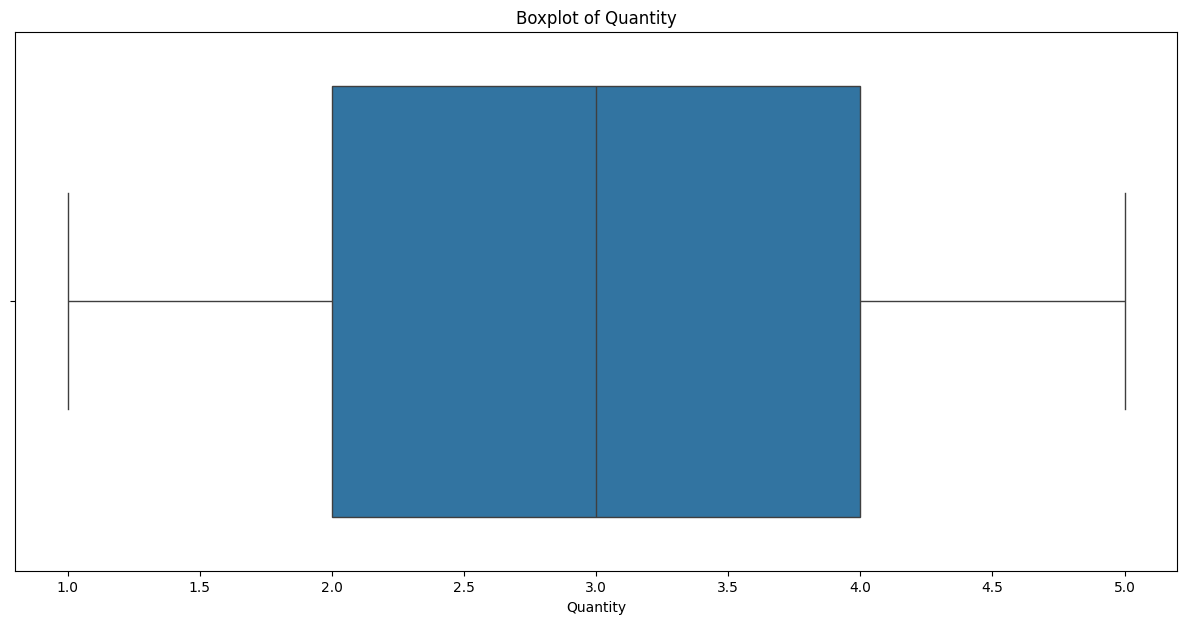

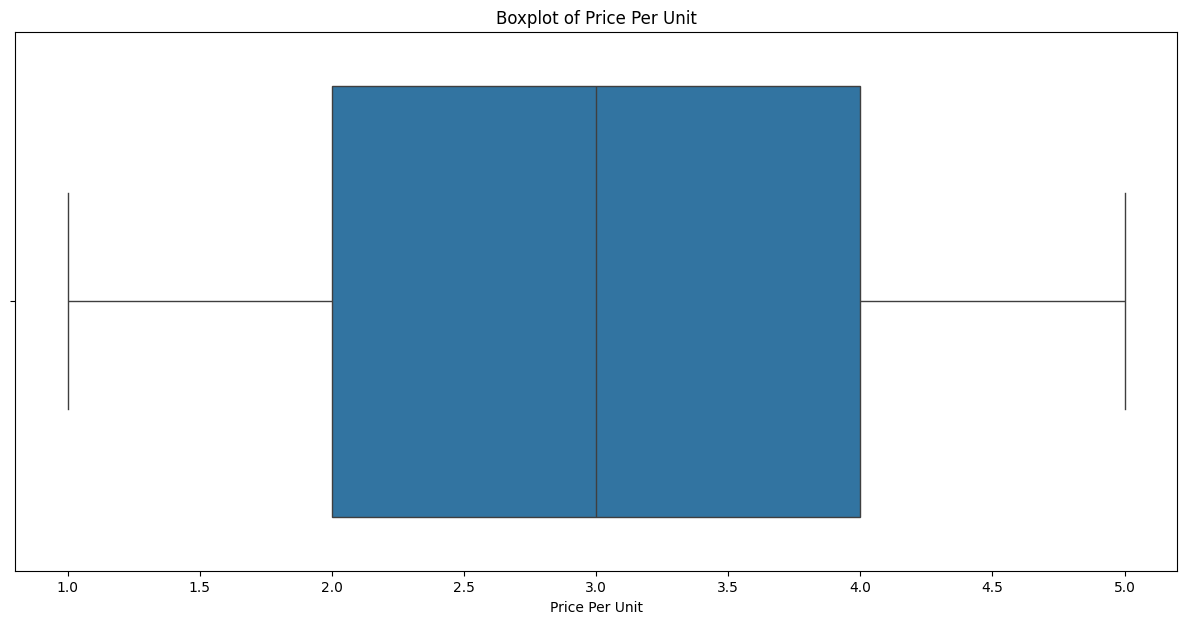

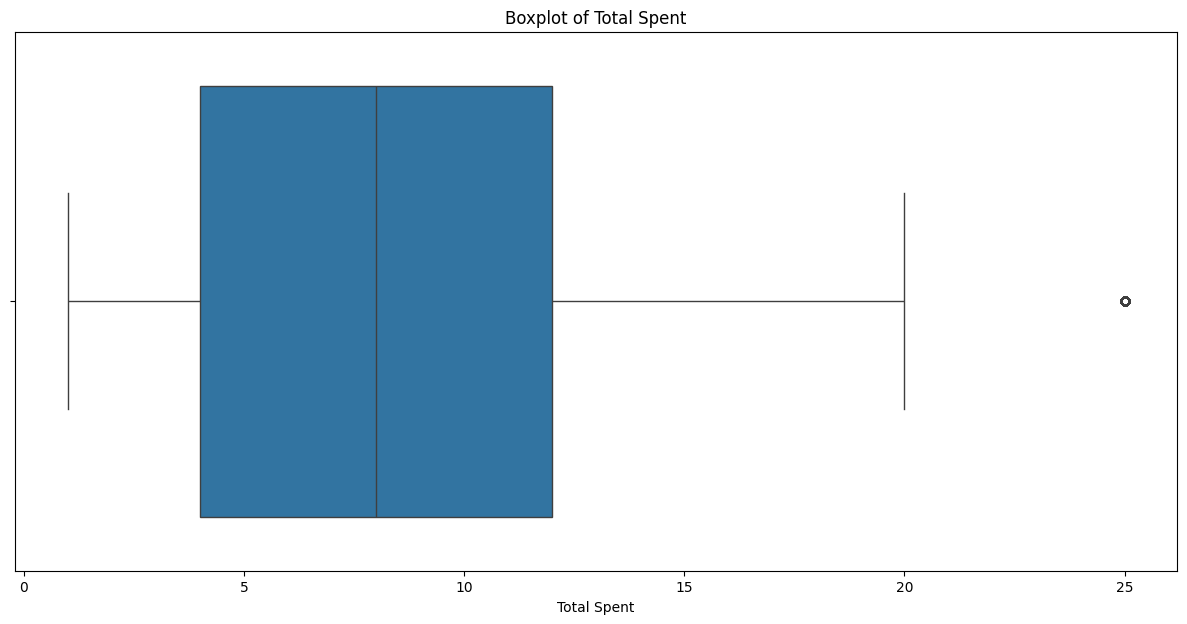

In [377]:
import matplotlib.pyplot as plt
import seaborn as sns
cols = ['Quantity', 'Price Per Unit', 'Total Spent']
for col in cols:
  plt.figure(figsize=(15, 7))
  sns.boxplot(x=df[col])
  plt.title(f'Boxplot of {col}')
  plt.show()

The outlier points seen in the boxplots are highly likey real observations, we can deduce that there is no outliers because the max and min values in each numerical columns fall within the expected range

In [378]:
df.to_csv('cafe_sales_cleaned.csv', index=False)